In [1]:
 !pip install --upgrade langchain transformers

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
from folium import Map
from geopy.geocoders import Nominatim
import time
import requests
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
!unzip /content/data-test-main.zip

Archive:  /content/data-test-main.zip
3a9ebce1ee6e7a14fbedf482a3a1cb701bffcee9
replace data-test-main/all_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## Read data

In [4]:
data_df = pd.read_csv("/content/data-test-main/all_data.csv")

In [5]:
data_df.shape

(186850, 6)

In [6]:
data_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


## Data clearning

### Detect the number of rows that contains NaN

In [7]:
num_nan_rows = int(data_df.isna().any(axis=1).sum())


In [8]:
num_nan_rows

545

The number of rows that have NaN is negligeable compared to the total so we'll not consider them and delete them

In [9]:
data_df_cleaned = data_df.dropna()

In [10]:
data_df_cleaned

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"
...,...,...,...,...,...,...
186845,259353,AAA Batteries (4-pack),3,2.99,09/17/19 20:56,"840 Highland St, Los Angeles, CA 90001"
186846,259354,iPhone,1,700,09/01/19 16:00,"216 Dogwood St, San Francisco, CA 94016"
186847,259355,iPhone,1,700,09/23/19 07:39,"220 12th St, San Francisco, CA 94016"
186848,259356,34in Ultrawide Monitor,1,379.99,09/19/19 17:30,"511 Forest St, San Francisco, CA 94016"


We'll consider only the 2 products mentionned AAA Batteries (4-pack) and Thinkpad laptop

In [11]:
data_df_cleaned["Product"].value_counts()

,count
Product,
USB-C Charging Cable,21903
Lightning Charging Cable,21658
AAA Batteries (4-pack),20641
AA Batteries (4-pack),20577
Wired Headphones,18882
Apple Airpods Headphones,15549
Bose SoundSport Headphones,13325
27in FHD Monitor,7507
iPhone,6842


In [12]:
data_df_cleaned = data_df_cleaned[data_df_cleaned["Product"].isin(["AAA Batteries (4-pack)","ThinkPad Laptop"])]

In [13]:
 data_df_cleaned["city"] = data_df_cleaned["Purchase Address"].str.split(",").str[1]
 data_df_cleaned["state"] = "("+data_df_cleaned["Purchase Address"].str.split(",").str[2].str[:3]+")"

/tmp/ipython-input-2900836089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["city"] = data_df_cleaned["Purchase Address"].str.split(",").str[1]
/tmp/ipython-input-2900836089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["state"] = "("+data_df_cleaned["Purchase Address"].str.split(",").str[2].str[:3]+")"


In [14]:
data_df_cleaned[["city","state"]]

,city,state
20,New York City,( NY)
28,Portland,( OR)
32,San Francisco,( CA)
45,San Francisco,( CA)
54,Boston,( MA)
...,...,...
186829,Boston,( MA)
186835,San Francisco,( CA)
186836,San Francisco,( CA)
186840,Dallas,( TX)


In [15]:
data_df_cleaned["zone_commande"]= data_df_cleaned["city"] + data_df_cleaned["state"]

/tmp/ipython-input-2212933191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["zone_commande"]= data_df_cleaned["city"] + data_df_cleaned["state"]


In [16]:
data_df_cleaned["zone_commande"].unique()

array([' New York City( NY)', ' Portland( OR)', ' San Francisco( CA)',
       ' Boston( MA)', ' Dallas( TX)', ' Los Angeles( CA)',
       ' Austin( TX)', ' Seattle( WA)', ' Portland( ME)', ' Atlanta( GA)'],
      dtype=object)

In [17]:
data_df_cleaned["Quantity Ordered"] = data_df_cleaned["Quantity Ordered"].astype(int)

/tmp/ipython-input-571011265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["Quantity Ordered"] = data_df_cleaned["Quantity Ordered"].astype(int)


In [18]:
data_df_cleaned

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,city,state,zone_commande
20,176575,AAA Batteries (4-pack),1,2.99,04/27/19 00:30,"433 Hill St, New York City, NY 10001",New York City,( NY),New York City( NY)
28,176583,AAA Batteries (4-pack),2,2.99,04/20/19 12:00,"146 Jackson St, Portland, OR 97035",Portland,( OR),Portland( OR)
32,176586,AAA Batteries (4-pack),2,2.99,04/10/19 17:00,"365 Center St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA)
45,176598,AAA Batteries (4-pack),2,2.99,04/21/19 20:33,"294 Park St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA)
54,176607,AAA Batteries (4-pack),2,2.99,04/18/19 12:11,"689 10th St, Boston, MA 02215",Boston,( MA),Boston( MA)
...,...,...,...,...,...,...,...,...,...
186829,259338,AAA Batteries (4-pack),2,2.99,09/02/19 21:29,"666 Lakeview St, Boston, MA 02215",Boston,( MA),Boston( MA)
186835,259344,AAA Batteries (4-pack),2,2.99,09/10/19 23:33,"721 Madison St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA)
186836,259345,ThinkPad Laptop,1,999.99,09/21/19 23:12,"406 Dogwood St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA)
186840,259349,AAA Batteries (4-pack),1,2.99,09/01/19 22:14,"911 River St, Dallas, TX 75001",Dallas,( TX),Dallas( TX)


## Data visualisation

### Geographic visualisation

In [19]:
## get the longitude and the latitude
geolocator = Nominatim(user_agent="geo_visualization")

def get_coordinates(city_state):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": city_state,
        "format": "json",
        "limit": 1
    }
    response = requests.get(url, params=params, headers={"User-Agent": "Mozilla/5.0"})
    data = response.json()

    if len(data) > 0:
        return float(data[0]["lat"]), float(data[0]["lon"])



    else:
        return None, None

In [20]:
coords = [get_coordinates(loc.strip()) for loc in data_df_cleaned["zone_commande"].unique()]

In [21]:
coords

[(40.7127281, -74.0060152),
 (45.5202471, -122.674194),
 (37.7792588, -122.4193286),
 (42.3554334, -71.060511),
 (32.7762719, -96.7968559),
 (34.0536909, -118.242766),
 (30.2711286, -97.7436995),
 (47.6038321, -122.330062),
 (43.6634708, -70.2584907),
 (33.7544657, -84.3898151)]

In [22]:
coords_mapping = dict(zip(data_df_cleaned["zone_commande"].unique(), coords))

In [23]:
data_df_cleaned["lat"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][0] if coords_mapping[x] else None)
data_df_cleaned["lon"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][1] if coords_mapping[x] else None)

/tmp/ipython-input-1081114749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["lat"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][0] if coords_mapping[x] else None)
/tmp/ipython-input-1081114749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned["lon"] = data_df_cleaned["zone_commande"].map(lambda x: coords_mapping[x][1] if coords_mapping[x] else None)


In [24]:
data_df_cleaned[["lat","lon"]]

,lat,lon
20,40.712728,-74.006015
28,45.520247,-122.674194
32,37.779259,-122.419329
45,37.779259,-122.419329
54,42.355433,-71.060511
...,...,...
186829,42.355433,-71.060511
186835,37.779259,-122.419329
186836,37.779259,-122.419329
186840,32.776272,-96.796856


In [25]:
map_center = [data_df_cleaned['lat'].mean(), data_df_cleaned['lon'].mean()]
m = folium.Map(location=map_center, zoom_start=2)
for idx, row in data_df_cleaned.iterrows():
    if pd.notna(row['lat']) and pd.notna(row['lon']):
        folium.Marker([row['lat'], row['lon']], popup=row['zone_commande']).add_to(m)

heat_data = data_df_cleaned[['lat','lon']].dropna().values.tolist()
HeatMap(heat_data).add_to(m)

In [26]:
# the visualisation of the map always crash the notebook
#m

In [27]:
data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
# Extraire le mois pour regrouper par saison
data_df_cleaned["Month"] = data_df_cleaned['Order Date'].dt.strftime('%b')
data_df_cleaned["Year"] = data_df_cleaned["Order Date"]

/tmp/ipython-input-2258910446.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
/tmp/ipython-input-2258910446.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
/tmp/ipython-input-2258910446.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

### Saison visualisation (according to the month)

In [28]:
data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
data_df_cleaned['year'] = data_df_cleaned['Order Date'].dt.year
data_df_cleaned['month'] = data_df_cleaned['Order Date'].dt.strftime('%b')   # Month names
data_df_cleaned['month_num'] = data_df_cleaned['Order Date'].dt.month

/tmp/ipython-input-809167613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['Order Date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)
/tmp/ipython-input-809167613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['year'] = data_df_cleaned['Order Date'].dt.year
/tmp/ipython-input-809167613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [29]:
data_df_cleaned.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,city,state,zone_commande,lat,lon,Month,Year,year,month,month_num
20,176575,AAA Batteries (4-pack),1,2.99,2019-04-27 00:30:00,"433 Hill St, New York City, NY 10001",New York City,( NY),New York City( NY),40.712728,-74.006015,Apr,2019-04-27 00:30:00,2019,Apr,4
28,176583,AAA Batteries (4-pack),2,2.99,2019-04-20 12:00:00,"146 Jackson St, Portland, OR 97035",Portland,( OR),Portland( OR),45.520247,-122.674194,Apr,2019-04-20 12:00:00,2019,Apr,4
32,176586,AAA Batteries (4-pack),2,2.99,2019-10-04 17:00:00,"365 Center St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA),37.779259,-122.419329,Oct,2019-10-04 17:00:00,2019,Oct,10
45,176598,AAA Batteries (4-pack),2,2.99,2019-04-21 20:33:00,"294 Park St, San Francisco, CA 94016",San Francisco,( CA),San Francisco( CA),37.779259,-122.419329,Apr,2019-04-21 20:33:00,2019,Apr,4
54,176607,AAA Batteries (4-pack),2,2.99,2019-04-18 12:11:00,"689 10th St, Boston, MA 02215",Boston,( MA),Boston( MA),42.355433,-71.060511,Apr,2019-04-18 12:11:00,2019,Apr,4


In [30]:
data_df_cleaned["year"].value_counts()

,count
year,
2019,24764
2020,5


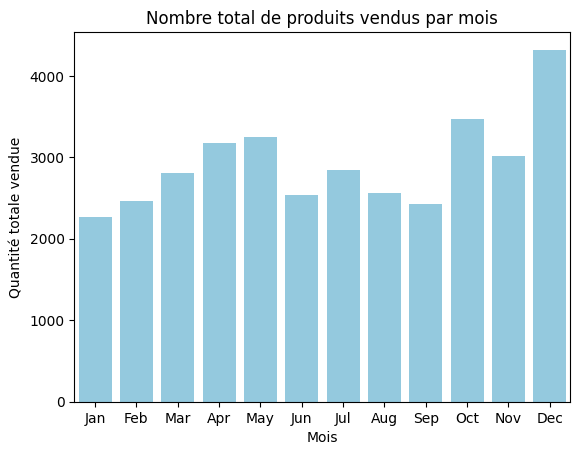

In [31]:
monthly_sales = data_df_cleaned.groupby(['month_num','month'])['Quantity Ordered'].sum().reset_index()
monthly_sales = monthly_sales.sort_values('month_num')

plt.figure()
sns.barplot(data=monthly_sales, x='month', y='Quantity Ordered', color='skyblue')
plt.title("Nombre total de produits vendus par mois")
plt.xlabel("Mois")
plt.ylabel("Quantité totale vendue")
plt.show()

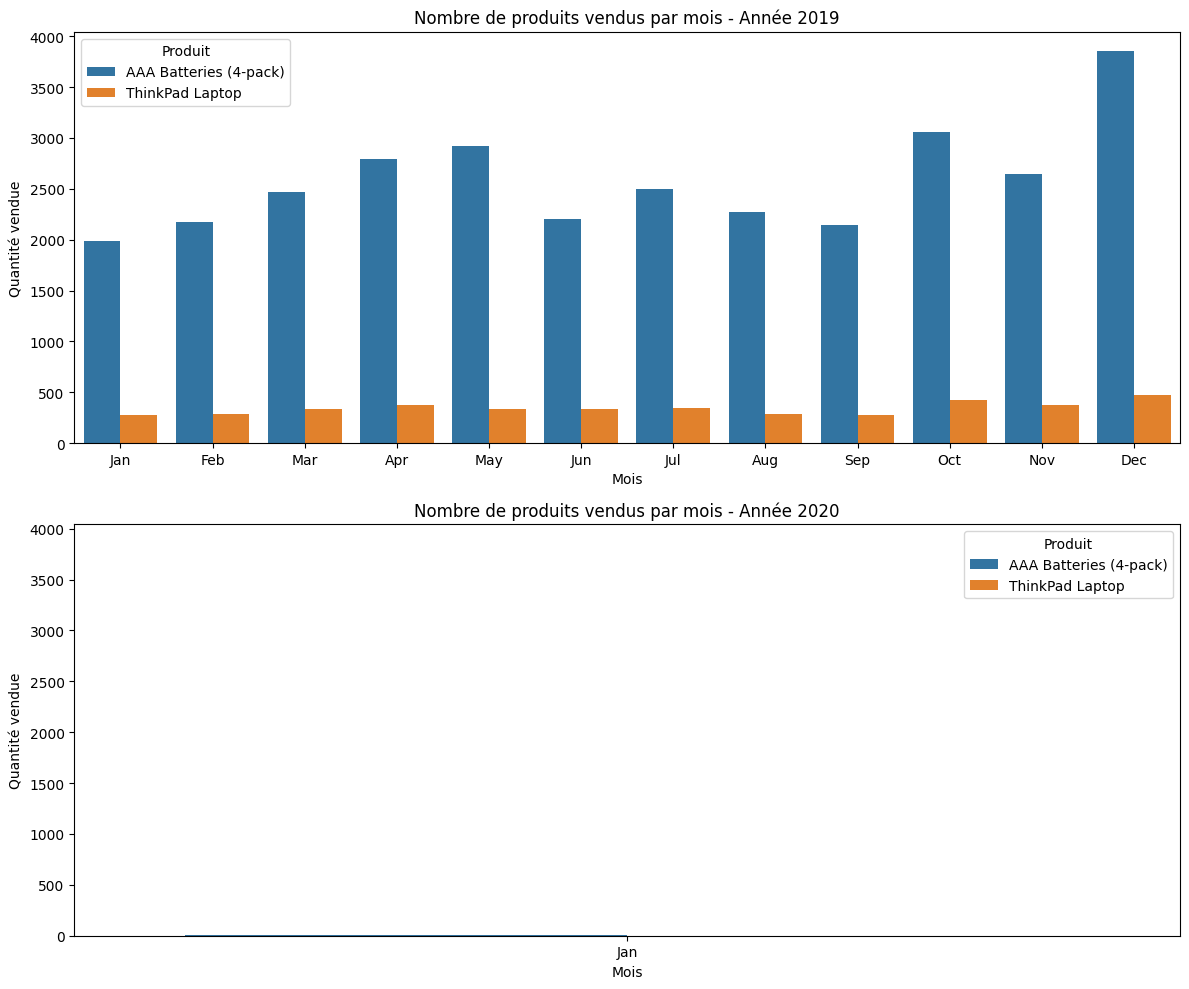

In [32]:
years = sorted(data_df_cleaned['year'].unique())
num_years = len(years)

# Create subplots
fig, axes = plt.subplots(num_years, 1, figsize=(12, 5*num_years), sharey=True)

if num_years == 1:
    axes = [axes]  # Make it iterable if only one year

for ax, year in zip(axes, years):
    # Filter data for the year
    df_year = data_df_cleaned[data_df_cleaned['year'] == year]

    # Aggregate quantity sold per product per month
    monthly_sales = df_year.groupby(['month_num','month','Product'])['Quantity Ordered'].sum().reset_index()

    # Sort by month number to ensure chronological order
    monthly_sales = monthly_sales.sort_values('month_num')

    # Plot barplot
    sns.barplot(
        data=monthly_sales,
        x='month',
        y='Quantity Ordered',
        hue='Product',
        ax=ax
    )
    ax.set_title(f"Nombre de produits vendus par mois - Année {year}")
    ax.set_xlabel("Mois")
    ax.set_ylabel("Quantité vendue")
    ax.legend(title="Produit")

plt.tight_layout()
plt.show()

## Feature Engineering

In [33]:
monthly_sales = data_df_cleaned.groupby(['Product','year','month'])['Quantity Ordered'].sum().reset_index()

# Map month name to month number
month_map = {
    'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,
    'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12
}
monthly_sales['month_num'] = monthly_sales['month'].map(month_map)

# Now create datetime using year and month number
monthly_sales['ds'] = pd.to_datetime(dict(year=monthly_sales['year'], month=monthly_sales['month_num'], day=1))

# Rename target column for Prophet
monthly_sales.rename(columns={'Quantity Ordered':'y'}, inplace=True)

monthly_sales.sort_values(['Product','ds'], inplace=True)
monthly_sales.head()

,Product,year,month,y,month_num,ds
4,AAA Batteries (4-pack),2019,Jan,1987,1,2019-01-01
3,AAA Batteries (4-pack),2019,Feb,2177,2,2019-02-01
7,AAA Batteries (4-pack),2019,Mar,2469,3,2019-03-01
0,AAA Batteries (4-pack),2019,Apr,2796,4,2019-04-01
8,AAA Batteries (4-pack),2019,May,2919,5,2019-05-01


In [34]:
data_df_cleaned['order date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)

monthly_sales = data_df_cleaned.groupby(
    ['Product','zone_commande','year','month_num']
)['Quantity Ordered'].sum().reset_index()

monthly_sales.sort_values(['Product','zone_commande','year','month_num'], inplace=True)

/tmp/ipython-input-4249577697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df_cleaned['order date'] = pd.to_datetime(data_df_cleaned['Order Date'], dayfirst=True)


In [35]:
monthly_sales

,Product,zone_commande,year,month_num,Quantity Ordered
0,AAA Batteries (4-pack),Atlanta( GA),2019,1,134
1,AAA Batteries (4-pack),Atlanta( GA),2019,2,170
2,AAA Batteries (4-pack),Atlanta( GA),2019,3,186
3,AAA Batteries (4-pack),Atlanta( GA),2019,4,217
4,AAA Batteries (4-pack),Atlanta( GA),2019,5,237
...,...,...,...,...,...
240,ThinkPad Laptop,Seattle( WA),2019,8,16
241,ThinkPad Laptop,Seattle( WA),2019,9,25
242,ThinkPad Laptop,Seattle( WA),2019,10,33
243,ThinkPad Laptop,Seattle( WA),2019,11,33


## Model training


RMSE (last 5 months): 88.02067184403332

RMSE per product per zone:
                   Product        zone_commande        RMSE
0   AAA Batteries (4-pack)         Atlanta( GA)   23.303535
1   AAA Batteries (4-pack)          Austin( TX)   19.104536
2   AAA Batteries (4-pack)          Boston( MA)   57.798839
3   AAA Batteries (4-pack)          Dallas( TX)   22.855941
4   AAA Batteries (4-pack)     Los Angeles( CA)   89.605957
5   AAA Batteries (4-pack)   New York City( NY)  155.248704
6   AAA Batteries (4-pack)        Portland( ME)    8.243042
7   AAA Batteries (4-pack)        Portland( OR)   59.978479
8   AAA Batteries (4-pack)   San Francisco( CA)  333.881400
9   AAA Batteries (4-pack)         Seattle( WA)   31.571052
10         ThinkPad Laptop         Atlanta( GA)    3.972755
11         ThinkPad Laptop          Austin( TX)    6.251504
12         ThinkPad Laptop          Boston( MA)   15.120594
13         ThinkPad Laptop          Dallas( TX)    5.826376
14         ThinkPad Laptop     

/tmp/ipython-input-1729642148.py:66: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_prod_zone = test.groupby(['Product','zone_commande']).apply(


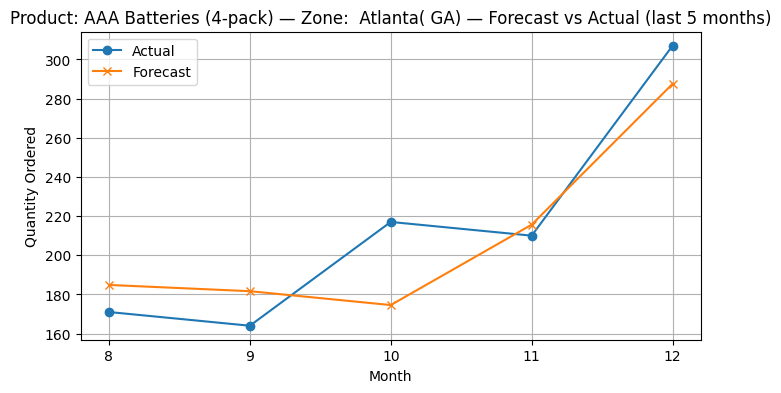

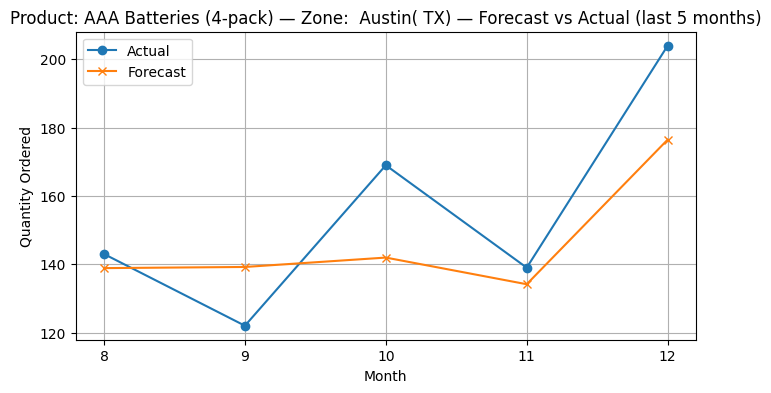

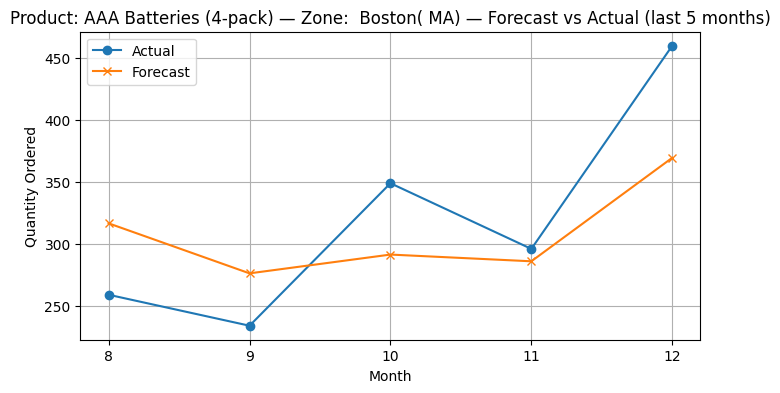

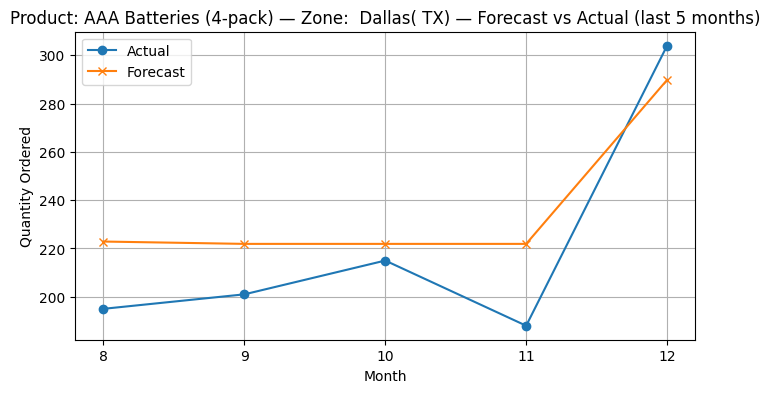

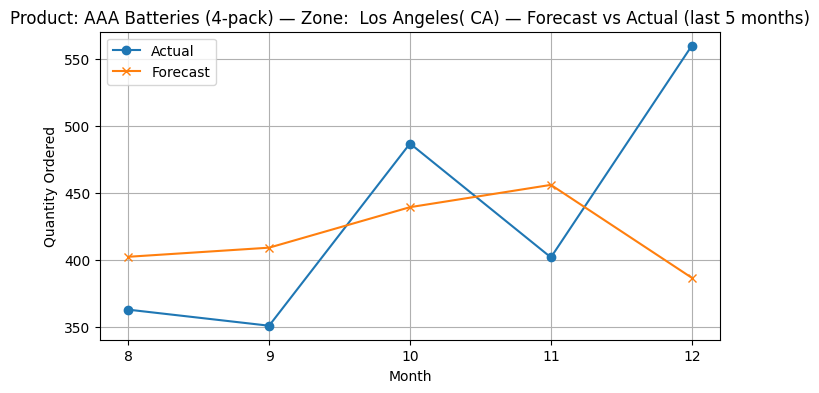

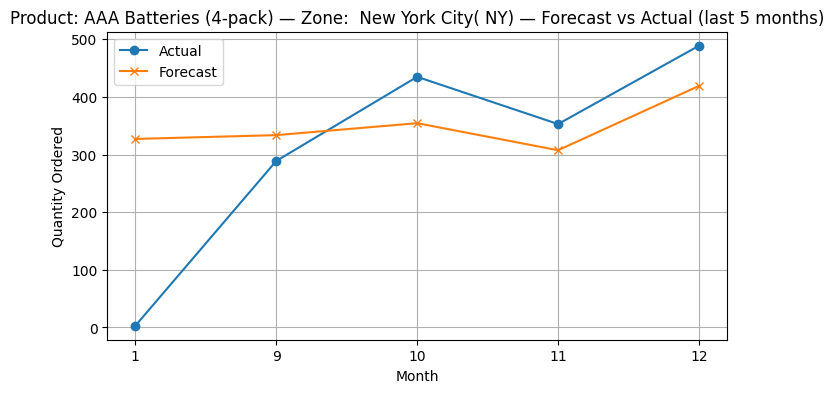

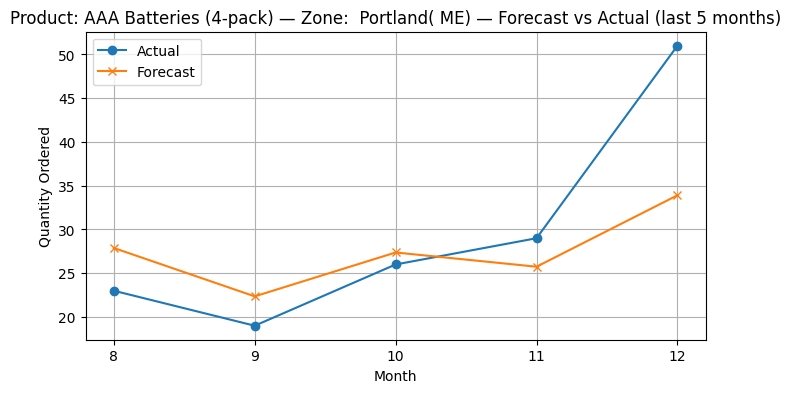

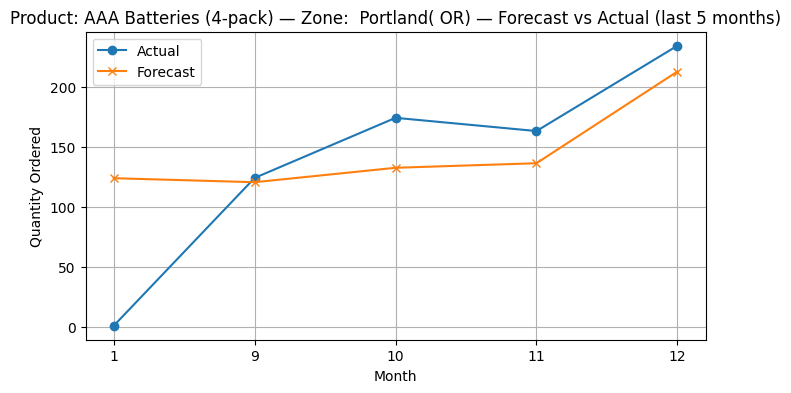

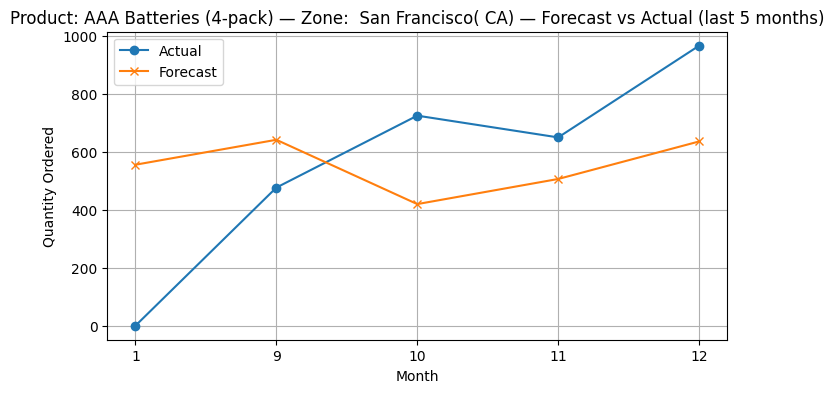

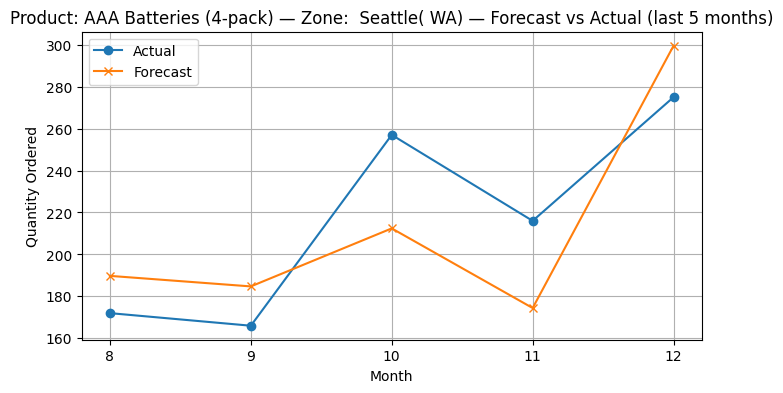

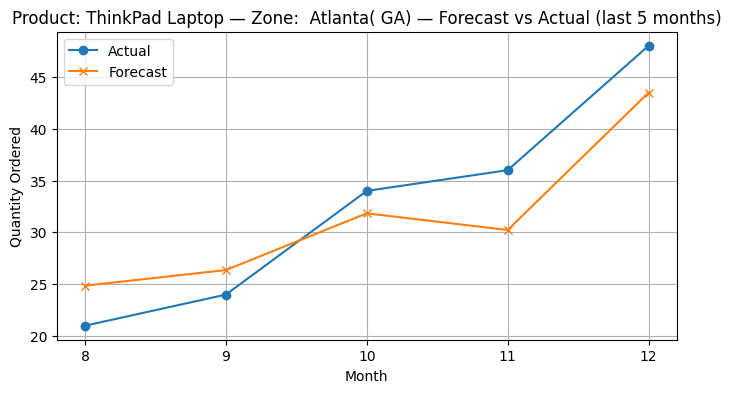

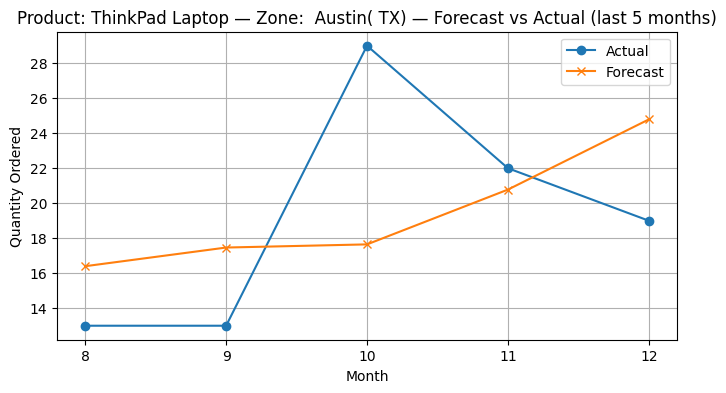

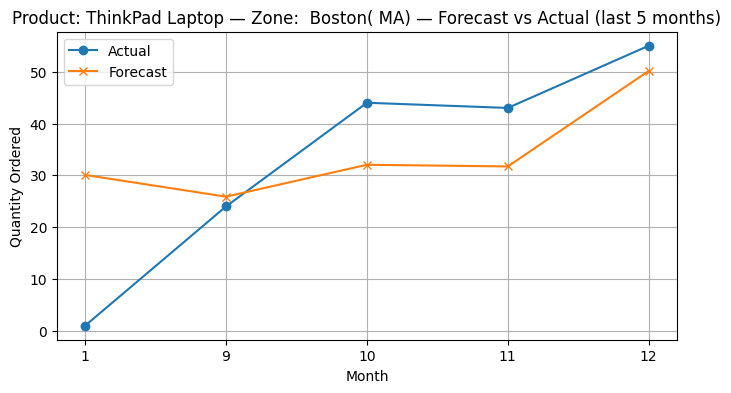

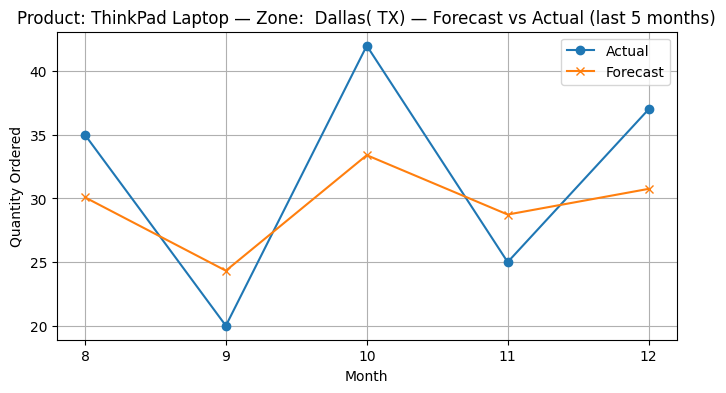

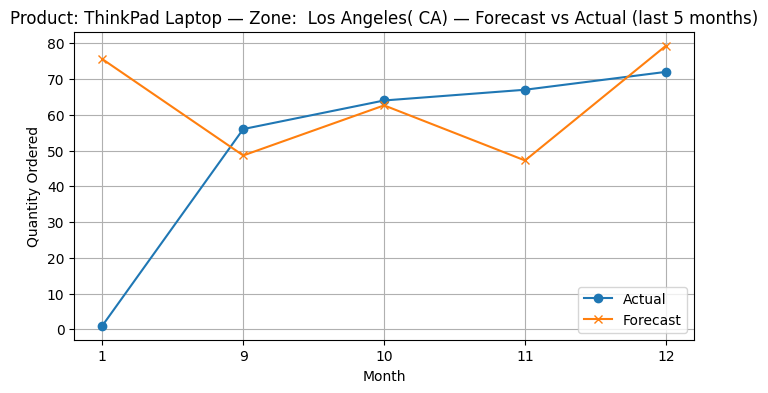

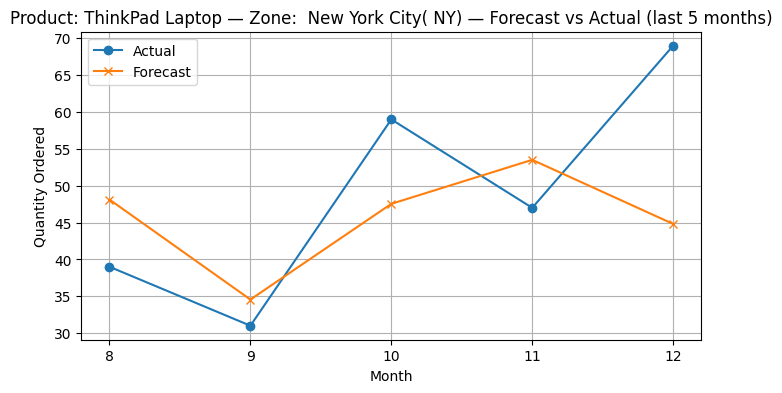

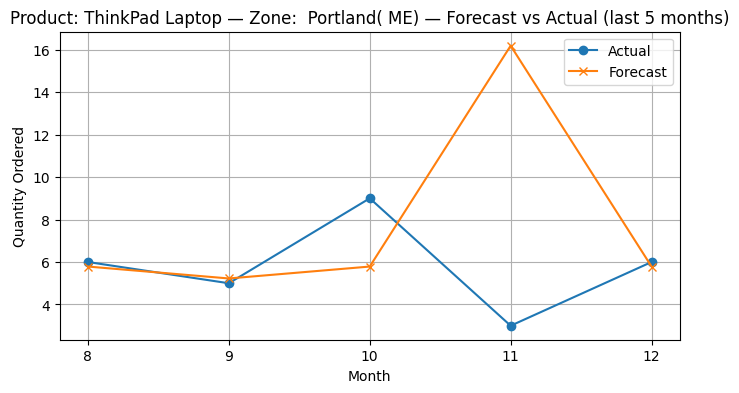

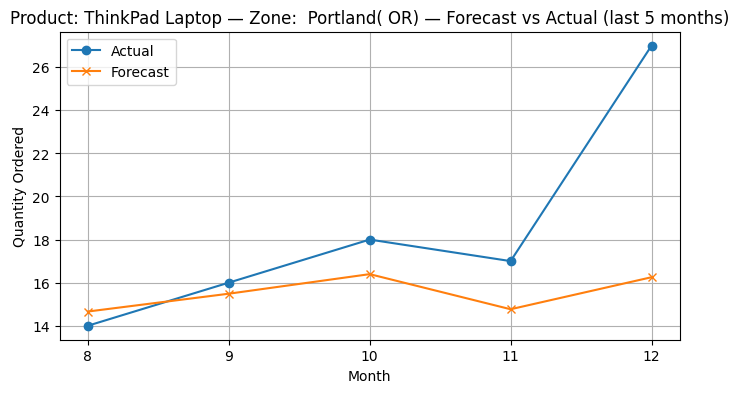

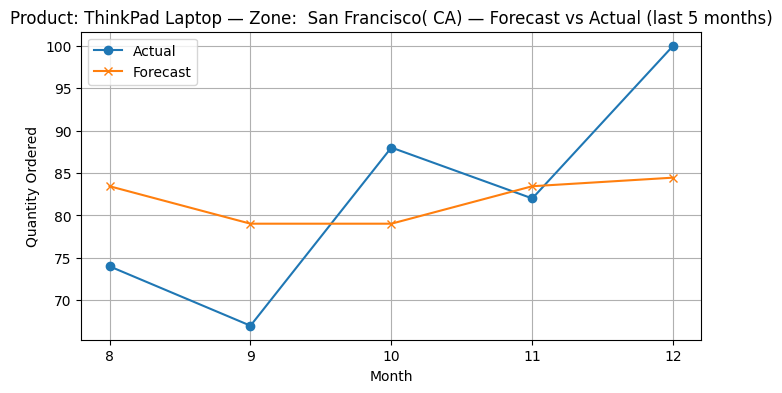

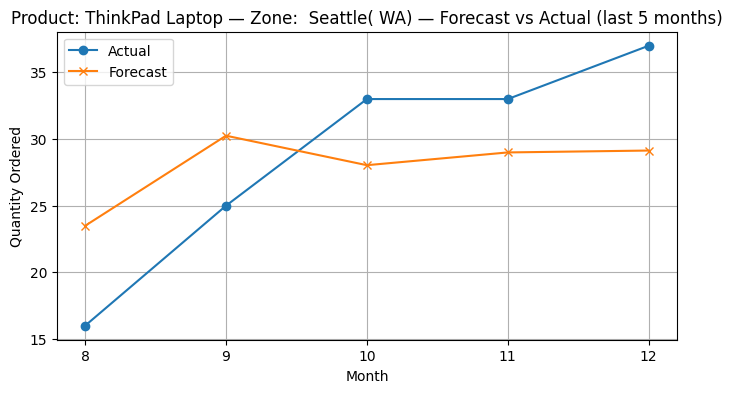

In [36]:

df = monthly_sales.copy()

# encode categorical variables (Name of the products and the name of the zones)
le_product = LabelEncoder()
le_zone = LabelEncoder()

df['product_enc'] = le_product.fit_transform(df['Product'])
df['zone_enc'] = le_zone.fit_transform(df['zone_commande'])

# Feature engineer according the lag and rolling for time series forecasting
df = df.sort_values(['Product','zone_commande','year','month_num'])
df['lag_1'] = df.groupby(['Product','zone_commande'])['Quantity Ordered'].shift(1)
df['lag_2'] = df.groupby(['Product','zone_commande'])['Quantity Ordered'].shift(2)
df['rolling_3'] = df.groupby(['Product','zone_commande'])['Quantity Ordered']\
                    .transform(lambda x: x.rolling(3, min_periods=1).mean())

df = df.dropna().reset_index(drop=True)

# we'll use for training and validation the 7 months and the last 5 months for test
def split_last_5(group):
    if len(group) <= 5:
        return group.iloc[0:0], group
    return group.iloc[:-5], group.iloc[-5:]

train_list = []
test_list = []

for _, g in df.groupby(['Product','zone_commande']):
    tr, ts = split_last_5(g)
    train_list.append(tr)
    test_list.append(ts)

train = pd.concat(train_list).reset_index(drop=True)
test = pd.concat(test_list).reset_index(drop=True)

def split_val(group, frac=0.2):
    n = len(group)
    n_val = max(1, int(n * frac))
    return group.iloc[:n-n_val], group.iloc[n-n_val:]

train_final_list = []
val_list = []

for _, g in train.groupby(['Product','zone_commande']):
    tr, va = split_val(g)
    train_final_list.append(tr)
    val_list.append(va)

train_final = pd.concat(train_final_list).reset_index(drop=True)
val = pd.concat(val_list).reset_index(drop=True)

# Train the model
features = ['lag_1','lag_2','rolling_3','product_enc','zone_enc']
target = 'Quantity Ordered'

model = XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
model.fit(train_final[features], train_final[target],
          eval_set=[(val[features], val[target])],
          verbose=False)

# Prediction of the model rmse and the predicted quantity values
test['pred'] = model.predict(test[features])
rmse_global = np.sqrt(mean_squared_error(test[target], test['pred']))
print("\nRMSE (last 5 months):", rmse_global)

rmse_per_prod_zone = test.groupby(['Product','zone_commande']).apply(
    lambda g: np.sqrt(mean_squared_error(g[target], g['pred']))
).reset_index(name='RMSE')

print("\nRMSE per product per zone:")
print(rmse_per_prod_zone)


pred_per_prod_zone = test.groupby(['Product','zone_commande'])['pred'].sum().reset_index()
pred_per_prod_zone["pred"] = pred_per_prod_zone["pred"].astype(int)
pred_per_prod_zone = pred_per_prod_zone.sort_values(['Product','pred'], ascending=[True, False])

print("\nPredicted quantity per product per zone (last 5 months):")
print(pred_per_prod_zone)


# Forecast values vs Actual values
products = test['Product'].unique()
zones = test['zone_commande'].unique()

for p in products:
    for z in zones:
        g = test[(test['Product']==p) & (test['zone_commande']==z)].copy()
        if g.empty:
            continue

        g = g.sort_values('month_num')

        plt.figure(figsize=(8,4))
        plt.plot(range(1,len(g)+1), g[target], marker='o', label="Actual")
        plt.plot(range(1,len(g)+1), g['pred'], marker='x', label="Forecast")
        plt.title(f"Product: {p} — Zone: {z} — Forecast vs Actual (last 5 months)")
        plt.xlabel("Month")
        plt.ylabel("Quantity Ordered")
        plt.xticks(range(1,len(g)+1), g['month_num'].astype(int))
        plt.legend()
        plt.grid()
        plt.show()


### Save the model, encoders for the app of the deployment

In [37]:
import joblib
joblib.dump(model,"model.pkl")
joblib.dump(le_zone,"zone.pkl")
joblib.dump(le_product,"product.pkl")

['product.pkl']

## Test of using LLM for the help of user

In [38]:
pred_per_prod_zone

,Product,zone_commande,pred
8,AAA Batteries (4-pack),San Francisco( CA),2760
4,AAA Batteries (4-pack),Los Angeles( CA),2094
5,AAA Batteries (4-pack),New York City( NY),1742
2,AAA Batteries (4-pack),Boston( MA),1539
3,AAA Batteries (4-pack),Dallas( TX),1178
9,AAA Batteries (4-pack),Seattle( WA),1060
0,AAA Batteries (4-pack),Atlanta( GA),1044
1,AAA Batteries (4-pack),Austin( TX),730
7,AAA Batteries (4-pack),Portland( OR),725
6,AAA Batteries (4-pack),Portland( ME),137


In [39]:
!!pip install -U langchain langchain-community transformers pandas

['Requirement already satisfied: langchain in /usr/local/lib/python3.12/dist-packages (1.1.0)',
 'Requirement already satisfied: langchain-community in /usr/local/lib/python3.12/dist-packages (0.4.1)',
 'Requirement already satisfied: transformers in /usr/local/lib/python3.12/dist-packages (4.57.2)',
 'Requirement already satisfied: pandas in /usr/local/lib/python3.12/dist-packages (2.3.3)',
 'Requirement already satisfied: langchain-core<2.0.0,>=1.1.0 in /usr/local/lib/python3.12/dist-packages (from langchain) (1.1.0)',
 'Requirement already satisfied: langgraph<1.1.0,>=1.0.2 in /usr/local/lib/python3.12/dist-packages (from langchain) (1.0.3)',
 'Requirement already satisfied: pydantic<3.0.0,>=2.7.4 in /usr/local/lib/python3.12/dist-packages (from langchain) (2.11.10)',
 'Requirement already satisfied: langchain-classic<2.0.0,>=1.0.0 in /usr/local/lib/python3.12/dist-packages (from langchain-community) (1.0.0)',
 'Requirement already satisfied: SQLAlchemy<3.0.0,>=1.4.0 in /usr/local/l

In [40]:

from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFacePipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import pandas as pd


table_text = pred_per_prod_zone.to_string(index=False)
prompt_text = f"""
Vous êtes un assistant de gestion de stock. Voici la quantité prévue pour chaque produit et zone:

{table_text}

Répondez aux questions suivantes en français:
1) Pour chaque produit, quelle zone doit recevoir le plus de stock en priorité?
2) Comparez la quantité prévue entre Dallas et Houston pour chaque produit.
"""
model_name = "google/flan-t5-small"

print(f"Loading tokenizer and model: {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    task="text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.0
)

llm = HuggingFacePipeline(pipeline=pipe)
prompt = PromptTemplate(
    input_variables=[],
    template=prompt_text
)


print("Running the LLM Chain...")
chain = LLMChain(prompt=prompt, llm=llm)

response = chain.run({})


print("\n--- LLM Response ---")
print(response)
print("--------------------")

In [ ]:
!pip show langchain
